   # Project: Automatic classification of skin lesions (melanoma detection)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import glob
import os
import pandas as pd
from skimage.measure import label, regionprops
from skimage.feature import local_binary_pattern
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

#Feature Selection
from sklearn.feature_selection import SelectKBest, f_classif

#Pearson Correlation
from scipy.stats import pearsonr

#Normalizing data
from sklearn.preprocessing import MinMaxScaler

#Decision Tree
from sklearn.tree import DecisionTreeClassifier

#Metrics
from sklearn import metrics

#Roc CUrve
from sklearn.metrics import roc_curve, auc

#Logistic Regression
from sklearn.linear_model import LogisticRegression

#SVMs
from sklearn import svm

#kNN
from sklearn.neighbors import KNeighborsClassifier

#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

#Evaluation
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc


## I Database :

Among the given documents in campus, a folder containing three types of picture was available . This folder, named PROJECT_Data, contains :

-.The pictures of the skin lesions
-.The pictures of the skin lesion segmentation
-.The associated superpixel image of the skin lesion

Before extracting the features of each image, it is important to separate these three types of images into separate lists, so we can manipulate them more easily after. 

As the pictures of the skin lesions are the only one in jpg format, they are easy to isolate.
The associated segmented and superpixel pictures are in consecutive order, so I have stored them in a list and then split them into two lists by taking the even indexes for segmented images and odd indexes for superpixels indices

In [2]:
img_dir = r"C:\Users\Smail\Documents\TB3 Image and Pattern Recognition\Skin lesion project/PROJECT_Data/*.jpg"
img_dir2 = r"C:\Users\Smail\Documents\TB3 Image and Pattern Recognition\Skin lesion project/PROJECT_Data/*.png"

images_originales = [] #Skin lesion pictures
autres_images = [] # Other pictures ( intermediate variable )
images_segmentation = [] #Segmented skin lesions 
images_superpixel = [] # Superpixels associated to the skin lesions

files = glob.glob(img_dir)
files2 = glob.glob(img_dir2)

for file in files:
    img = cv2.imread(file)
    images_originales.append(img)

for file in files2:
    img = cv2.imread(file)
    autres_images.append(img)
    
n = len(autres_images)
for i in range(0,n,2):
    images_segmentation.append(autres_images[i])

for i in range(1,n,2):
    images_superpixel.append(autres_images[i])
    


Let's verify that our lists contains the correct elements :

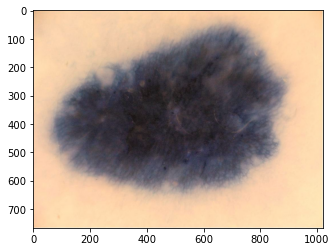

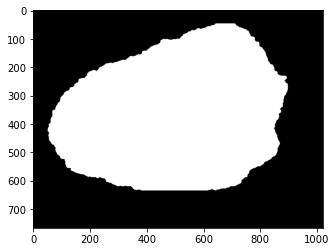

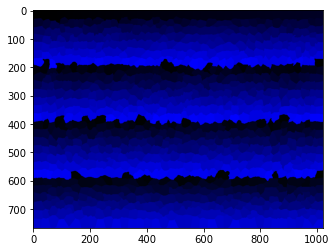

In [3]:
plt.imshow(images_originales[0])
plt.show()
plt.imshow(images_segmentation[0])
plt.show()
plt.imshow(images_superpixel[0])

We can see that the segmented picture goes along with the original picture

Let's now import the dataframe that contains the labels associated to each picture 

In [4]:
#### Import the dataframe with the labels ####

data = pd.read_csv(r'ISIC-2017_Data_GroundTruth_Classification.csv')
data.head()






FileNotFoundError: [Errno 2] No such file or directory: 'ISIC-2017_Data_GroundTruth_Classification.csv'

# 2.Feature Extraction

## 1. Morphological Features

As suggested by the instructions given, let's extract features from the different pictures we have in order to have some predictors for our machine learning model. 

We can extract morphological features from the segmented pictures by using the function *regionprops* in the package *skimage.measure*. Thanks to this function, we have access to 10 morphological features associated to each skin lesion

The function **get_shape_feature** extracts the morphological features of a single picture

In [ ]:
#Extract the features from each image

from skimage.measure import label, regionprops

#Morphological features

def get_shape_feature(image):
    
    
    shape_features = []
    
    #Extract the region of interest
    
    image_region = label(image)
    
    #Extract the shape features
    
    props = regionprops(image_region)
    
    shape_features.append(props[0].area)
    shape_features.append(props[0].eccentricity)
    shape_features.append(props[0].perimeter)
    shape_features.append(props[0].equivalent_diameter)
    shape_features.append(props[0].extent)
    shape_features.append(props[0].filled_area)
    shape_features.append(props[0].minor_axis_length)
    shape_features.append(props[0].major_axis_length)
    shape_features.append(props[0].major_axis_length / props[0].minor_axis_length)
    shape_features.append(props[0].solidity)
    
    return np.array(shape_features)



For some reason, my segmented pictures have 3 dimensions, so I have converted them to grayscale images using the function 
**rgb2gray**

After that, I use the function **all_features** which gathers the features of our 200 pictures into one single dataframe

In [ ]:
def rgb2gray(image_liste):
    
    n = len(image_liste)
    for i in range(n):
        image_liste[i] = cv2.cvtColor(image_liste[i],cv2.COLOR_RGB2GRAY)
        
    return image_liste

images_segmentation = rgb2gray(images_segmentation)


def all_features(image_liste):
    
    dataframe = np.empty(shape=(200,10))
    
    n = len(image_liste)
    
    for i in range(n):
        
        dataframe[i,:] = get_shape_feature(image_liste[i])
    
    df = pd.DataFrame(dataframe, columns = ['Area','Eccentricity','Perimeter','Equivalent Diameter','Extent','Filled Area','Minor AL','Major AL','Major/Minor','Solidity'])

    return df

#test

features = all_features(images_segmentation)
features.head()

## 2. Texture features

We are going to extract the texture features using the **Local Binary Patterns** on the original pictures.
**Local Binary Patterns** is an algorithm that turns a 2D image into another image in order to detect the particular textures of this image. Thanks to the function **local_binary_pattern** of the package skimage.feature, we can apply the Local Binary Pattern algorithm to each component of our original skin lesion images. We can then plot the histogram associated to each picture and see which pixel intensity value is the most represented.

Let's see if the histogram of each component is different or is the same. If it is the same, we can then use only one component and reduce the processing complexity of our code



In [ ]:
# Extract descriptors with Local binary patterns

method = 'uniform'

image_test_red = images_originales[129][:,:,0] #red channel
image_test_green = images_originales[129][:,:,1] #green channel
image_test_blue = images_originales[129][:,:,2] #blue channel

lbp_test_red = local_binary_pattern(image_test_red,8,1,method)
lbp_test_green = local_binary_pattern(image_test_green,8,1,method)
lbp_test_blue = local_binary_pattern(image_test_blue,8,1,method)

hist_test_red,bins1 = np.histogram(lbp_test_red,bins = 256)
hist_test_green,bins2 = np.histogram(lbp_test_green,bins = 256)
hist_test_blue,bins3 = np.histogram(lbp_test_blue,bins = 256)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (21, 5))

ax1.plot(hist_test_red)
ax1.set_title("Histogram of red component")
ax2.plot(hist_test_green)
ax2.set_title("Histogram of green component")
ax3.plot(hist_test_blue)
ax3.set_title("Histogram of blue component")



    





We see that for each channel, the histogram is the same, we are thus going to use only one channel for the processing of our skin lesion images

We use the function **extract_lbp** to extract the texture features from the skin lesion images
    



In [ ]:
def extract_lbp(liste_image,nbPoints,radius):
    
    n = len(liste_image)
    
    df_features = np.empty(shape=(200,256))
    
    for i in range(n):
        
        img = liste_image[i][:,:,0] #extract red component
        lbp = local_binary_pattern(img,nbPoints,radius)
        hist,bins = np.histogram(lbp,bins=256)
        
        df_features[i,:] = hist
        
    df_features = pd.DataFrame(df_features, columns = ['Descriptor ' + str(i) for i in range(256)])
    
    return df_features

texture_features = extract_lbp(images_originales,8,1)

texture_features.head()



## 3. Label vector and Feature selection

We have to import the label vector that contains the true labels associated to each picture

In [ ]:
Y = []

dir_images = r'C:\Users\Smail\Documents\TB3 Image and Pattern Recognition\Skin lesion project\PROJECT_Data'

from skimage import util
import csv

for image_path in glob.glob(dir_images + "/*.jpg"):

    #print("[INFO] Processing image " + image_path)

    img_ori = cv2.imread(image_path)
    img = util.img_as_ubyte(img_ori)
    basename=os.path.basename(image_path)
    splitname=os.path.splitext(basename)[0]
    
    csv_file=csv.reader(open("ISIC-2017_Data_GroundTruth_Classification.csv","r"), delimiter=",")
    for row in csv_file:
        if splitname==row[0]:
            Y=np.append(Y,int(float(row[1])))




In [ ]:
print(Y)

# Morphological Feature Selection

To select the most relevant morphological features, we are going to use the ANOVA criterion with the f_classif function

In [ ]:
features = SelectKBest(f_classif, k = 5).fit_transform(features, Y)
features = pd.DataFrame(features, columns = ["Geometrical Feature " + str(i) for i in range(5)])

features.drop(['Geometrical Feature 2'],1)
features.head()



## Texture Feature Correlation

To select the relevent LBP Features, we are going to use the Pearson Formula

In [ ]:

#Pearson correlation

#Creating the DataFrame
pearson_corr = pd.DataFrame()
pearson_corr["Descriptors"] = texture_features.columns

pearson_corr.head()

In [ ]:
L = []

#Computing the Pearson Correlation
for column in texture_features.columns:
    L.append(pearsonr(texture_features[column], Y))

#Adding the p-value
pearson_corr["Absolute Pearson’s correlation"] = abs(np.array([element[0] for element in L]))
pearson_corr["p-value"] = [element[1] for element in L]

#Capturing the results
scores = pearson_corr.sort_values(by=['Absolute Pearson’s correlation'], ascending=False)[:10]


In [ ]:
scores.head()

In [ ]:
#Keep only the important features
selected_features = pd.DataFrame()
for col in list(scores["Descriptors"]):
    selected_features["LBP " + col] = texture_features[col]

predictors = pd.concat([features, selected_features], axis = 1)
predictors

We now have our array of predictors ! We can normalize the data and split it into a train set and a test set.

I have chosen :  

In [ ]:
#Normalization of the data

from sklearn.model_selection import train_test_split

min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(predictors)
X = pd.DataFrame(X, columns = predictors.columns)
print("Data normalized.")


#Train Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
print("Data split.")
print("Train predictor shape: ", X_train.shape)
print("Test predictor shape: ", X_test.shape)

# 4. Classification using different models

We are going to try a lot of classifiers and choose the best ones according to machine learning criteria such as the :
  * Accuracy
  * F1_Score
  * Confusion Matrix
  * ROC and AUC


In [ ]:

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression


In [ ]:
names = ["Nearest_Neighbors", "Linear_SVM", "Polynomial_SVM", "RBF_SVM", "Gaussian_Process",
         "Gradient_Boosting", "Decision_Tree", "Extra_Trees", "Random_Forest", "Neural_Net", "AdaBoost",
         "Naive_Bayes", "SGD", "Logistic Regression"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025,probability = True),
    SVC(kernel="poly", degree=3, C=0.025,probability = True),
    SVC(kernel="rbf", C=1, gamma=2,probability = True),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0),
    DecisionTreeClassifier(max_depth=5),
    ExtraTreesClassifier(n_estimators=10, min_samples_split=2),
    RandomForestClassifier(max_depth=5, n_estimators=100),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(n_estimators=100),
    GaussianNB(),
    SGDClassifier(loss="hinge", penalty="l2"),
    LogisticRegression()]


# Evaluation of our models

To evaluate the performance of our models , let's compute all the metrics we have talkes aboute before

In [ ]:
scores = []
f1_scores = []
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

for name, clf in zip(names, classifiers):
    fit = clf.fit(X_train, Y_train)
    predictions = fit.predict(X_test)
    score = accuracy_score(predictions, Y_test)
    scores.append(score.mean())
    
for name, clf in zip(names, classifiers):
    fit = clf.fit(X_train, Y_train)
    predictions = fit.predict(X_test)
    #score = clf.score(X_test, Y_test)
    score = f1_score(Y_test,predictions)
    f1_scores.append(score)

In [ ]:
df = pd.DataFrame()
df['name'] = names
df['score'] = scores
df



In [ ]:
f1scores = pd.DataFrame()
f1scores['name'] = names
f1scores['f1 score'] = f1_scores
f1scores

# Score

In [ ]:
import seaborn as sns

sns.set(style="whitegrid")
ax = sns.barplot(y="name", x="score", data=df)



# F1 _ Score

In [ ]:
sns.set(style="whitegrid")
ax = sns.barplot(y="name", x="f1 score", data=f1scores)

# Confusion Matrix

In [ ]:
>>> from sklearn.metrics import plot_confusion_matrix


for names, clf in zip(names, classifiers):
    
    clf.fit(X_train,Y_train)
    plt.figure()
    plot_confusion_matrix(clf,X_test,Y_test)
    plt.title(names)
   
    

# ROC CURVES and AUC

In [ ]:
#ROC CURVES 

from sklearn.metrics import roc_curve, roc_auc_score
nbclass = len(classifiers)

fig, axs = plt.subplots(nbclass, 1, figsize = (25, 10))

names = ["Nearest_Neighbors", "Linear_SVM", "Polynomial_SVM", "RBF_SVM", "Gaussian_Process",
         "Gradient_Boosting", "Decision_Tree", "Extra_Trees", "Random_Forest", "Neural_Net", "AdaBoost",
         "Naive_Bayes", "SGD"]


for names , clf in zip(names, classifiers):
    
    clf.fit(X_train,Y_train)
    clf_probs = clf.predict_proba(X_test)
    clf_probs = clf_probs[:, 1]
    clf_auc = roc_auc_score(Y_test, clf_probs)
    clf_fpr, clf_tpr, _ = roc_curve(Y_test, clf_probs)
    plt.plot(clf_fpr, clf_tpr, linestyle='-', label= names + '(AUROC = %0.3f)' % clf_auc)
    plt.plot([0, 1], [0, 1],'r--')

    # Title
    plt.title('ROC Plot ' + names)
    # Axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # Show legend
    plt.legend() # 
    # Show plot
    plt.show()

    



# 6 Conclusion

According to the ROC curves and AUC, which is the most complete indicator of performance, the best models to detect **melanoms** are the
 * Decision Tree
 * Extra _ Trees
 * Random Forest
 
 We can reach an accuracy of 74%, which is not bad, but can be largely improved if we had more data, and more computational resources